In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv

In [2]:
load_dotenv()

api_key = os.getenv("ALPHA_VANTAGE_API_KEY")

ticker = "AAL"

url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

file_to_save = 'stock_market_data-%s.csv'%ticker

if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                        float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save)

# If the data is already there, just load it from the CSV
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [9]:
df = df.sort_values('Date')
df.head()
len(df)

4991

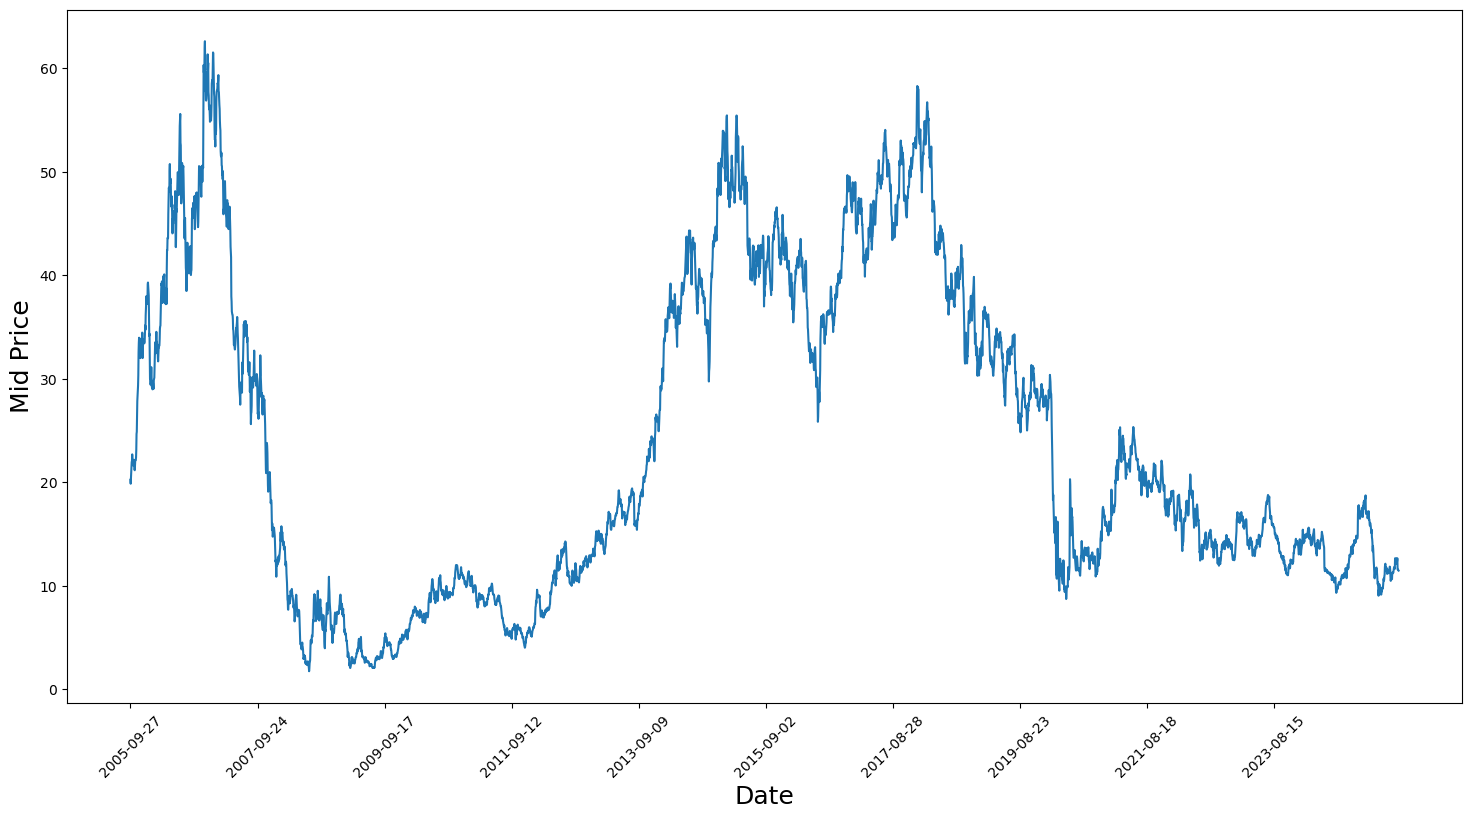

In [10]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [11]:
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = ((high_prices+low_prices)/2)

In [12]:
train_data = mid_prices[:4000]
test_data = mid_prices[4000:]

In [13]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [14]:
smoothing_window = 1000
n_samples = train_data.shape[0]

for di in range(0,n_samples - smoothing_window,smoothing_window):
    scaler.fit(train_data[di:di+smoothing_window, :])
    train_data[di:di+smoothing_window, :] = scaler.transform(train_data[di:di+smoothing_window, :])

scaler.fit(train_data[di+smoothing_window:, :])
train_data[di+smoothing_window:, :] = scaler.transform(train_data[di+smoothing_window:, :])